In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import arviz

import torch
import torch.distributions as td
import torch.nn.functional as F

from tqdm.auto import tqdm
from tabulate import tabulate
from collections import OrderedDict, namedtuple

import pyro
import pyro.distributions as pd
from pyro import poutine

In [3]:
pyro.__version__, torch.__version__

('1.6.0', '1.8.1+cu102')

In [4]:
random.seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)
torch.manual_seed(0)
rng = np.random.RandomState(0)

In [5]:
D = 10000
S = 999
TC = 100
data_samples = [
    td.Multinomial(probs=torch.ones(D)/100, total_count=TC).sample([S]),
    td.Multinomial(probs=torch.ones(D)/100, total_count=TC).sample([S]),
    td.Multinomial(probs=td.Dirichlet(torch.ones(D)).sample(), total_count=TC).sample([S]),
    td.Multinomial(probs=td.Dirichlet(torch.ones(D)).sample(), total_count=TC).sample([S]),
    td.Multinomial(probs=td.Dirichlet(torch.ones(D)/10).sample(), total_count=TC).sample([S]),
    td.Multinomial(probs=td.Dirichlet(torch.ones(D)/100).sample(), total_count=TC).sample([S]),
]
data = torch.stack([t for t in data_samples], 1)
_, G, _ = data.shape
print(f"S={S} G={G} D={D} data={data.shape}")

S=999 G=6 D=10000 data=torch.Size([999, 6, 10000])


In [6]:
group_names = ['U', 'U', 'D(1)', 'D(1)', 'D(0.1)', 'D(0.01)']

In [7]:
from probabll.bda.mmm import Family, MixedMembershipRD, Plotting

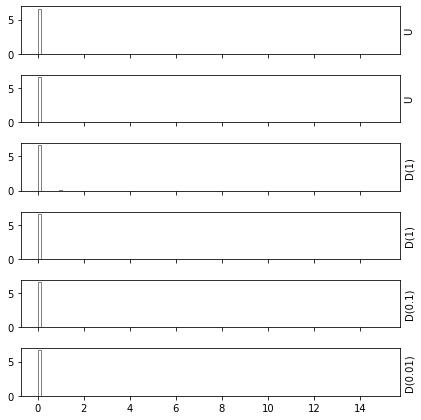

In [8]:
_ = Plotting.obs(data, group_names=group_names, sharex=False, sharey=False)

In [9]:
model = MixedMembershipRD(    
    #Family.Multinomial(D, TC, alpha=0.1),
    Family.DirichletMultinomial(D, TC, counts_a=10., counts_b=1.),
    T=10, 
    DP_alpha=0.1, 
    device=torch.device('cuda:0')
)

In [10]:
batch_size = 100

In [11]:
x = model.prepare(data.cpu().numpy())
x.shape

torch.Size([999, 6, 10000])

In [12]:
model.print_model_shapes(batch_size=batch_size)

    Trace Shapes:                      
     Param Sites:                      
    Sample Sites:                      
  components dist            |         
            value         10 |         
         log_prob            |         
      counts dist         10 | 10000   
            value         10 | 10000   
         log_prob         10 |         
         DPs dist            |         
            value          6 |         
         log_prob            |         
        beta dist          6 |     9   
            value          6 |     9   
         log_prob          6 |         
       omega dist            |     6 10
            value            |     6 10
         log_prob            |         
      groups dist            |         
            value          6 |         
         log_prob            |         
observations dist            |         
            value        100 |         
         log_prob            |         
           z dist    100   6 |         


In [13]:
model.print_guide_shapes()

  Trace Shapes:               
   Param Sites:               
          kappa  6     9      
     counts_loc 10 10000      
   counts_scale 10 10000      
  Sample Sites:               
components dist        |      
          value 10     |      
       log_prob        |      
    counts dist 10     | 10000
          value 10     | 10000
       log_prob 10     |      
       DPs dist        |      
          value  6     |      
       log_prob        |      
      beta dist  6     |     9
          value  6     |     9
       log_prob  6     |      


In [14]:
lr = 0.01 if batch_size is None else 0.005  # with mini batching you might need to lower the learning rate
model.fit(x, 2000, lr=lr, clip_norm=10., batch_size=batch_size)

  0%|          | 0/2000 [00:00<?, ?it/s]

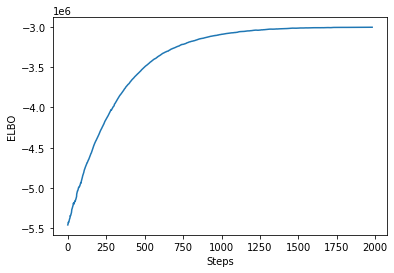

In [15]:
Plotting.elbo(model)

In [16]:
posterior = model.posterior_predict(num_samples=100, batch_size=batch_size)

In [17]:
print(tabulate([[rv_name, rv_t.shape] for rv_name, rv_t in posterior.items()]))

------  --------------------------------
counts  torch.Size([100, 1, 10, 10000])
beta    torch.Size([100, 1, 6, 9])
z       torch.Size([100, 100, 6])
obs     torch.Size([100, 100, 6, 10000])
omega   torch.Size([100, 1, 1, 6, 10])
------  --------------------------------


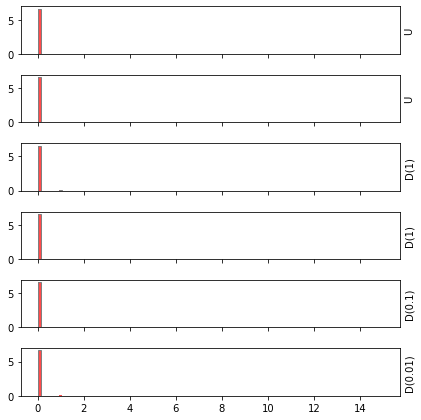

In [18]:
_ = Plotting.obs(x, pred=posterior['obs'], group_names=group_names, sharey='col')

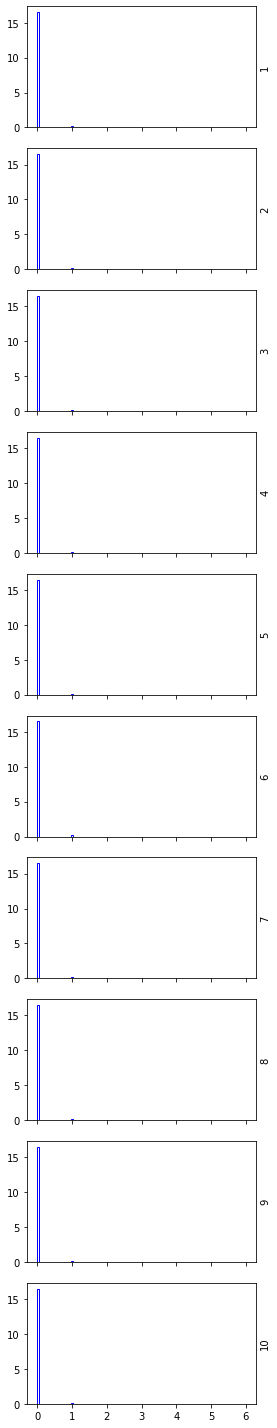

In [19]:
_ = Plotting.components(posterior, model, marginal=True)

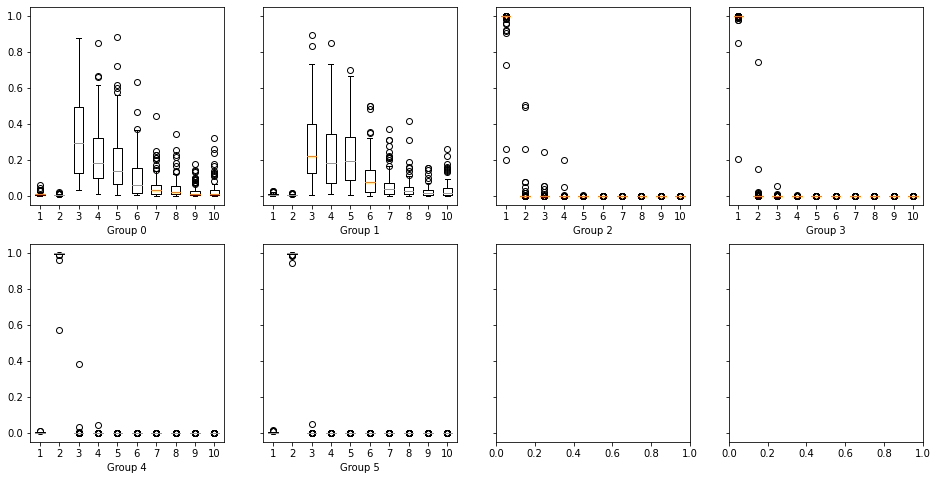

In [20]:
_ = Plotting.mixture_weights(posterior, model)

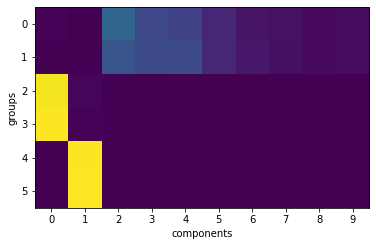

In [21]:
_ = Plotting.mean_mixture_weights(posterior, model)

In [22]:
if 'alpha' in posterior:
    posterior['alpha'].view(1, -1, 10).shape
    arviz.plot_forest(posterior['alpha'].view(1, -1, 10).cpu().numpy())

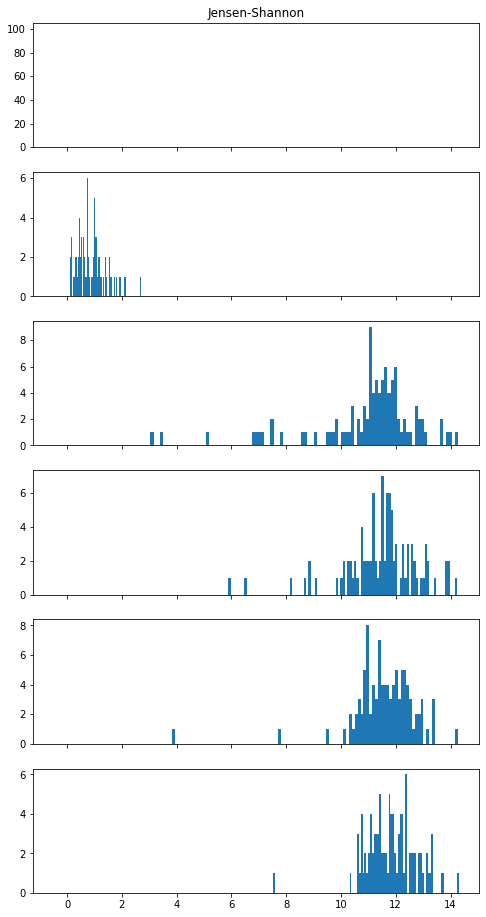

In [23]:
_ = Plotting.compare_mixture_weights(posterior, model, ref_group=0)

In [24]:
p_from = td.Multinomial(probs=torch.ones(D, device=model.device)/D, total_count=TC)

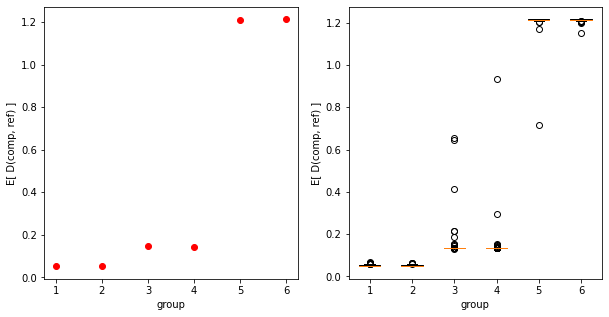

In [25]:
if 'DirichletMultinomial' in str(type(model.family)):
    _ = Plotting.expected_divergence(p_from, posterior, model, D=lambda p, q: td.kl_divergence(td.Categorical(logits=p.concentration.log()), td.Categorical(probs=q.probs)))
elif 'Multinomial' in str(type(model.family)):
    _ = Plotting.expected_divergence(p_from, posterior, model, D=lambda p, q: td.kl_divergence(td.Categorical(probs=p.probs), td.Categorical(probs=q.probs)))
else:
    raise ValueError("You need to implement the divergence function.")

Ideally the first 2 groups should have divergence close to 0 in the plots above.